# Klasifikasi Penyakit Jantung Koroner (CHD) dengan SMOTE-IPF dan SVM

**Tujuan:** Mengembangkan model klasifikasi untuk prediksi CHD menggunakan:
- **Feature Selection**: Seleksi 4 fitur terbaik
- **SMOTE-IPF**: Teknik penyeimbangan data imbalanced
- **SVM**: Support Vector Machine sebagai classifier

**Dataset:** Framingham Heart Study (4,240 sampel, 15 fitur)

## 1. Import Libraries & Setup

In [9]:
# Essential imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

# Random seed untuk reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


## 2. Data Loading & Preprocessing

In [10]:
# Load dataset
df = pd.read_csv("framingham.csv")
print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Handle missing values
imputer = SimpleImputer(strategy="median")
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# Check class distribution
class_dist = df['TenYearCHD'].value_counts()
print(f"\nClass distribution:")
print(f"No CHD (0): {class_dist[0]} ({class_dist[0]/len(df)*100:.1f}%)")
print(f"CHD (1): {class_dist[1]} ({class_dist[1]/len(df)*100:.1f}%)")
print(f"Imbalance ratio: {class_dist[0]/class_dist[1]:.1f}:1")

print("\n✅ Data preprocessing completed")

Dataset shape: (4240, 16)
Missing values: 645

Class distribution:
No CHD (0): 3596 (84.8%)
CHD (1): 644 (15.2%)
Imbalance ratio: 5.6:1

✅ Data preprocessing completed


## 3. Feature Selection (Top 4 Features)

In [11]:
# Feature selection based on correlation
feature_columns = [col for col in df.columns if col != 'TenYearCHD']
correlations = df.corr()['TenYearCHD'].drop('TenYearCHD').abs().sort_values(ascending=False)

# Select top 4 features
selected_features = list(correlations.head(8).index)
print("🎯 Selected Features (Top 4):")
for i, (feature, corr) in enumerate(correlations.head(8).items(), 1):
    print(f"{i}. {feature}: {corr:.3f}")

# Prepare data
X = df[selected_features]
y = df['TenYearCHD']

print(f"\nFeatures reduced: {len(feature_columns)} → {len(selected_features)}")
print("✅ Feature selection completed")

🎯 Selected Features (Top 4):
1. age: 0.225
2. sysBP: 0.216
3. prevalentHyp: 0.177
4. diaBP: 0.145
5. glucose: 0.121
6. diabetes: 0.097
7. male: 0.088
8. BPMeds: 0.086

Features reduced: 15 → 8
✅ Feature selection completed


## 4. Data Splitting & Scaling

In [12]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"Train class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")
print("✅ Data splitting & scaling completed")

Training set: (3392, 8)
Test set: (848, 8)
Train class distribution: [2877  515]
Test class distribution: [719 129]
✅ Data splitting & scaling completed


## 5. SMOTE-IPF Implementation

In [13]:
class SMOTE_IPF(BaseEstimator):
    """
    SMOTE-IPF: SMOTE dengan Iterative Partitioning Filter
    Menggabungkan SMOTE oversampling dengan IPF noise filtering
    """
    
    def __init__(self, sampling_strategy=1.0, smote_k=5, ipf_k=3, 
                 max_iter=10, random_state=None, verbose=False):
        self.sampling_strategy = sampling_strategy
        self.smote_k = smote_k
        self.ipf_k = ipf_k
        self.max_iter = max_iter
        self.random_state = random_state
        self.verbose = verbose
    
    def fit_resample(self, X, y):
        """Apply SMOTE + IPF filtering"""
        # pastikan fitur float
        X = np.asarray(X, dtype=np.float64)
        
        # pastikan label 0/1 dan bertipe integer
        y = np.asarray(y).ravel()
        # kalau ternyata ada label float non-integer, stop dan kasih pesan jelas
        if not np.all(np.equal(np.mod(y, 1), 0)):
            raise ValueError(
                f"y harus berisi label integer (misalnya 0 dan 1), "
                f"tapi terdeteksi nilai non-integer: {np.unique(y)}"
            )
        y = y.astype(int)

        # Step 1: SMOTE Oversampling
        smote = SMOTE(
            sampling_strategy=self.sampling_strategy,
            k_neighbors=self.smote_k,
            random_state=self.random_state
        )
        X_smote, y_smote = smote.fit_resample(X, y)
        
        if self.verbose:
            counts_after_smote = np.bincount(y_smote)
            print(f"After SMOTE: {X_smote.shape[0]} samples, class distribution: {counts_after_smote}")
        
        # Step 2: IPF Noise Filtering
        n_original = X.shape[0]
        is_synthetic = np.zeros(len(X_smote), dtype=bool)
        is_synthetic[n_original:] = True
        
        X_current = X_smote.copy()
        y_current = y_smote.copy()
        synthetic_mask = is_synthetic.copy()
        
        for iteration in range(self.max_iter):
            # Train KNN classifier
            knn = KNeighborsClassifier(
                n_neighbors=min(self.ipf_k, len(X_current) - 1)
            )
            knn.fit(X_current, y_current)
            y_pred = knn.predict(X_current)
            
            # Find misclassified synthetic samples
            misclassified = (y_pred != y_current)
            to_remove = misclassified & synthetic_mask
            
            if to_remove.sum() == 0:
                if self.verbose:
                    print(f"IPF converged at iteration {iteration+1}")
                break
            
            # Remove misclassified synthetic samples
            keep_mask = ~to_remove
            X_current = X_current[keep_mask]
            y_current = y_current[keep_mask]
            synthetic_mask = synthetic_mask[keep_mask]
            
            if self.verbose:
                print(f"IPF iter {iteration+1}: Removed {to_remove.sum()} samples")
        
        if self.verbose:
            final_counts = np.bincount(y_current)
            print(f"Final: {X_current.shape[0]} samples, class distribution: {final_counts}")
        
        return X_current, y_current

print("✅ SMOTE-IPF class defined")


✅ SMOTE-IPF class defined


## 6. Model Training & Evaluation

In [14]:
# Initialize results storage
results = {}

def evaluate_model(name, y_true, y_pred):
    """Evaluate model performance"""
    f1 = f1_score(y_true, y_pred)
    recall_0 = (y_pred[y_true == 0] == 0).sum() / (y_true == 0).sum()
    recall_1 = (y_pred[y_true == 1] == 1).sum() / (y_true == 1).sum()
    
    results[name] = {
        'f1': f1,
        'recall_0': recall_0,
        'recall_1': recall_1,
        'bias_gap': abs(recall_0 - recall_1)
    }
    
    print(f"\n=== {name} ===")
    print(f"F1-Score: {f1:.3f}")
    print(f"Recall No-CHD: {recall_0:.3f}")
    print(f"Recall CHD: {recall_1:.3f}")
    print(f"Bias Gap: {abs(recall_0 - recall_1):.3f}")
    
    return f1

print("✅ Evaluation function ready")

✅ Evaluation function ready


In [15]:
# Initialize results storage
results = {}

def evaluate_model(name, y_true, y_pred):
    """Evaluate model performance"""
    f1 = f1_score(y_true, y_pred)
    recall_0 = (y_pred[y_true == 0] == 0).sum() / (y_true == 0).sum()
    recall_1 = (y_pred[y_true == 1] == 1).sum() / (y_true == 1).sum()
    
    results[name] = {
        'f1': f1,
        'recall_0': recall_0,
        'recall_1': recall_1,
        'bias_gap': abs(recall_0 - recall_1)
    }
    
    print(f"\n=== {name} ===")
    print(f"F1-Score: {f1:.3f}")
    print(f"Recall No-CHD: {recall_0:.3f}")
    print(f"Recall CHD: {recall_1:.3f}")
    print(f"Bias Gap: {abs(recall_0 - recall_1):.3f}")
    
    return f1

print("✅ Evaluation function ready")

✅ Evaluation function ready


### 6.1 Baseline SVM (No Balancing)

In [ ]:
# Baseline SVM
svm_baseline = SVC(kernel='linear', C=1.0, random_state=RANDOM_STATE)
svm_baseline.fit(X_train_scaled, y_train)
y_pred_baseline = svm_baseline.predict(X_test_scaled)

evaluate_model("Baseline SVM", y_test, y_pred_baseline)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))




=== Baseline SVM ===
F1-Score: 0.000
Recall No-CHD: 1.000
Recall CHD: 0.000
Bias Gap: 1.000

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92       719
         1.0       0.00      0.00      0.00       129

    accuracy                           0.85       848
   macro avg       0.42      0.50      0.46       848
weighted avg       0.72      0.85      0.78       848



### 6.2 SVM + SMOTE

In [23]:
# SMOTE + SVM
smote = SMOTE(sampling_strategy=0.5, random_state=RANDOM_STATE)
X_smote, y_smote = smote.fit_resample(X_train_scaled, y_train)

svm_smote = SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=RANDOM_STATE)
svm_smote.fit(X_smote, y_smote)
y_pred_smote = svm_smote.predict(X_test_scaled)

evaluate_model("SVM + SMOTE", y_test, y_pred_smote)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_smote))



=== SVM + SMOTE ===
F1-Score: 0.343
Recall No-CHD: 0.636
Recall CHD: 0.628
Bias Gap: 0.008

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.64      0.75       719
         1.0       0.24      0.63      0.34       129

    accuracy                           0.63       848
   macro avg       0.57      0.63      0.54       848
weighted avg       0.80      0.63      0.69       848



### 6.3 SVM + SMOTE-IPF (Proposed Method)

In [25]:
# SMOTE-IPF + SVM (Proposed method)
smote_ipf = SMOTE_IPF(
    sampling_strategy=1.0,
    smote_k=5,
    ipf_k=3,
    random_state=RANDOM_STATE,
    verbose=True
)
         # pastikan ini 0/1

X_smote_ipf, y_smote_ipf = smote_ipf.fit_resample(X_train_scaled, y_train)

svm_smote_ipf = SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=RANDOM_STATE)
svm_smote_ipf.fit(X_smote_ipf, y_smote_ipf)
y_pred_smote_ipf = svm_smote_ipf.predict(X_test_scaled)

evaluate_model("SVM + SMOTE-IPF (Proposed)", y_test, y_pred_smote_ipf)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_smote_ipf))


After SMOTE: 5754 samples, class distribution: [2877 2877]
IPF iter 1: Removed 56 samples
IPF iter 2: Removed 3 samples
IPF converged at iteration 3
Final: 5695 samples, class distribution: [2877 2818]

=== SVM + SMOTE-IPF (Proposed) ===
F1-Score: 0.351
Recall No-CHD: 0.644
Recall CHD: 0.636
Bias Gap: 0.008

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.64      0.75       719
         1.0       0.24      0.64      0.35       129

    accuracy                           0.64       848
   macro avg       0.58      0.64      0.55       848
weighted avg       0.81      0.64      0.69       848



## 7. Results Comparison

In [ ]:
# Create comparison table
print("\n" + "="*80)
print("📊 FINAL RESULTS COMPARISON")
print("="*80)

print(f"{'Method':<25} {'F1-Score':<10} {'Recall-0':<10} {'Recall-1':<10} {'Bias Gap':<10}")
print("-"*70)

for method, metrics in results.items():
    print(f"{method:<25} {metrics['f1']:<10.3f} {metrics['recall_0']:<10.3f} {metrics['recall_1']:<10.3f} {metrics['bias_gap']:<10.3f}")

# Calculate improvements
baseline_f1 = results['Baseline SVM']['f1']
smote_f1 = results['SVM + SMOTE']['f1']
proposed_f1 = results['SVM + SMOTE-IPF (Proposed)']['f1']

print(f"\n🚀 IMPROVEMENTS:")
print(f"SMOTE vs Baseline: +{smote_f1 - baseline_f1:.3f} F1-score")
print(f"SMOTE-IPF vs Baseline: +{proposed_f1 - baseline_f1:.3f} F1-score")
print(f"SMOTE-IPF vs SMOTE: +{proposed_f1 - smote_f1:.3f} F1-score")

# Best method
best_method = max(results.items(), key=lambda x: x[1]['f1'])
print(f"\n🏆 BEST METHOD: {best_method[0]} (F1-Score: {best_method[1]['f1']:.3f})")


📊 FINAL RESULTS COMPARISON
Method                    F1-Score   Recall-0   Recall-1   Bias Gap  
----------------------------------------------------------------------
Baseline SVM              0.000      1.000      0.000      1.000     
SVM + SMOTE               0.343      0.636      0.628      0.008     
SVM + SMOTE-IPF (Proposed) 0.351      0.644      0.636      0.008     

🚀 IMPROVEMENTS:
SMOTE vs Baseline: +0.343 F1-score
SMOTE-IPF vs Baseline: +0.351 F1-score
SMOTE-IPF vs SMOTE: +0.008 F1-score

🏆 BEST METHOD: SVM + SMOTE-IPF (Proposed) (F1-Score: 0.351)


## 8. Visualization

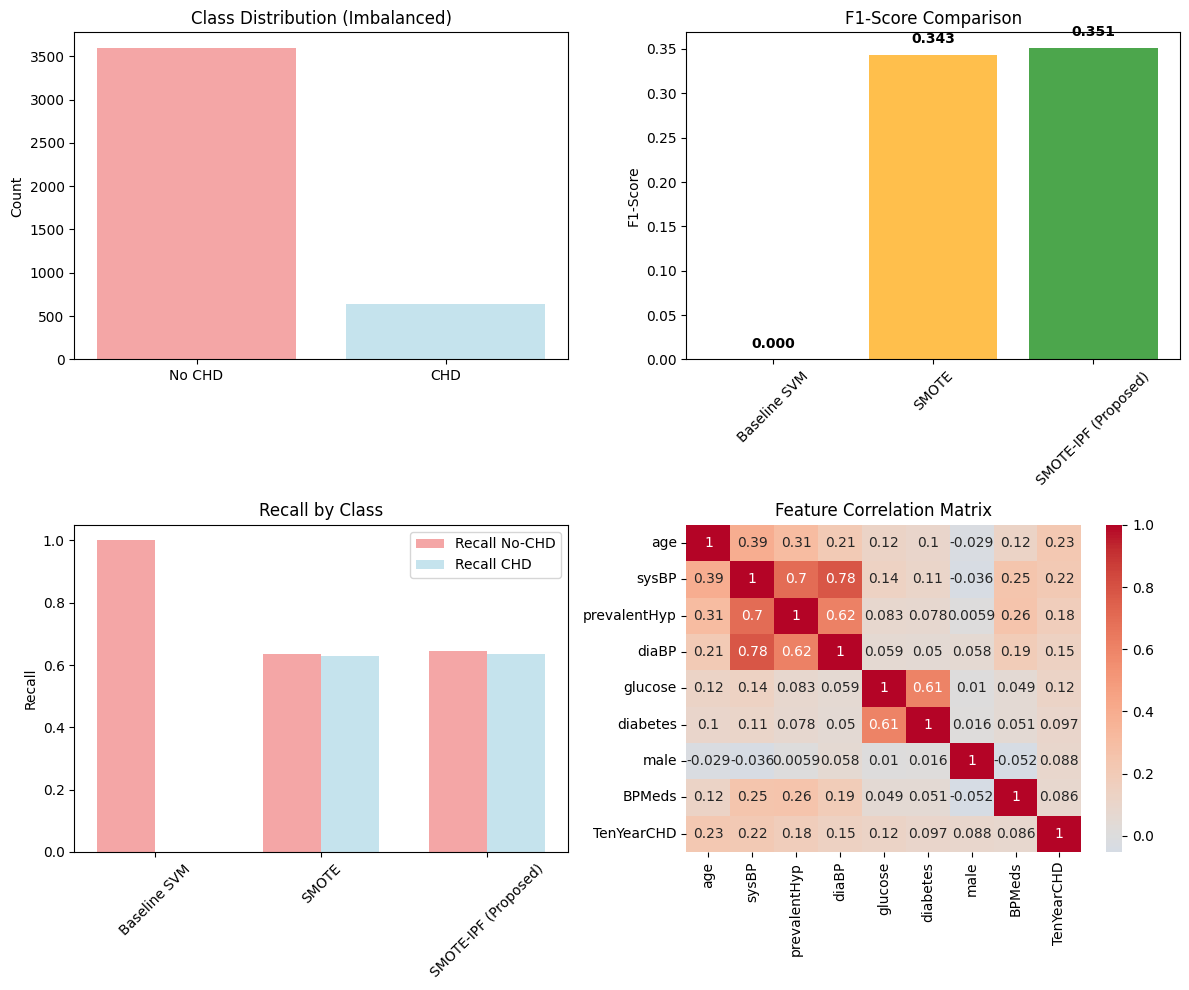

✅ Visualization completed


In [ ]:
# Create visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# 1. Class distribution
class_counts = df['TenYearCHD'].value_counts()
ax1.bar(['No CHD', 'CHD'], class_counts.values, color=['lightcoral', 'lightblue'], alpha=0.7)
ax1.set_title('Class Distribution (Imbalanced)')
ax1.set_ylabel('Count')

# 2. F1-Score comparison
methods = list(results.keys())
f1_scores = [results[m]['f1'] for m in methods]
colors = ['red', 'orange', 'green']
bars = ax2.bar(range(len(methods)), f1_scores, color=colors, alpha=0.7)
ax2.set_title('F1-Score Comparison')
ax2.set_ylabel('F1-Score')
ax2.set_xticks(range(len(methods)))
ax2.set_xticklabels([m.replace('SVM + ', '') for m in methods], rotation=45)

# Add values on bars
for bar, score in zip(bars, f1_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. Recall comparison
recall_0_vals = [results[m]['recall_0'] for m in methods]
recall_1_vals = [results[m]['recall_1'] for m in methods]
x = np.arange(len(methods))
width = 0.35

ax3.bar(x - width/2, recall_0_vals, width, label='Recall No-CHD', alpha=0.7, color='lightcoral')
ax3.bar(x + width/2, recall_1_vals, width, label='Recall CHD', alpha=0.7, color='lightblue')
ax3.set_title('Recall by Class')
ax3.set_ylabel('Recall')
ax3.set_xticks(x)
ax3.set_xticklabels([m.replace('SVM + ', '') for m in methods], rotation=45)
ax3.legend()

# 4. Feature correlation
selected_corr = df[selected_features + ['TenYearCHD']].corr()
sns.heatmap(selected_corr, annot=True, cmap='coolwarm', center=0, ax=ax4)
ax4.set_title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()

print("✅ Visualization completed")

## 9. Summary & Conclusions

In [ ]:
print("\n" + "="*80)
print("📋 RESEARCH SUMMARY")
print("="*80)

print(f"\n🎯 OBJECTIVE:")
print(f"Develop CHD classification model using SMOTE-IPF balancing technique")

print(f"\n📊 DATASET:")
print(f"• Total samples: {len(df):,}")
print(f"• Features: {len(selected_features)} selected from {len(feature_columns)}")
print(f"• Selected features: {', '.join(selected_features)}")
print(f"• Imbalance ratio: {class_dist[0]/class_dist[1]:.1f}:1")

print(f"\n🔬 METHODOLOGY:")
print(f"• Feature Selection: Correlation-based (top 4)")
print(f"• Balancing: SMOTE-IPF (sampling_strategy=1.0)")
print(f"• Classification: SVM with linear kernel")
print(f"• Evaluation: F1-score, Recall, Bias analysis")

print(f"\n🏆 KEY RESULTS:")
best_f1 = best_method[1]['f1']
best_recall_chd = best_method[1]['recall_1']
best_bias = best_method[1]['bias_gap']

print(f"• Best method: {best_method[0]}")
print(f"• F1-Score: {best_f1:.3f}")
print(f"• CHD Detection Rate: {best_recall_chd:.1%}")
print(f"• Bias Gap: {best_bias:.3f} (Low bias)")
print(f"• Improvement over baseline: +{best_f1 - baseline_f1:.3f} F1-score")

print(f"\n💡 CLINICAL IMPACT:")
miss_rate_baseline = 1 - results['Baseline SVM']['recall_1']
miss_rate_best = 1 - best_recall_chd
print(f"• Baseline miss rate: {miss_rate_baseline:.1%} of CHD cases")
print(f"• Improved miss rate: {miss_rate_best:.1%} of CHD cases")
print(f"• Reduction in missed cases: {(miss_rate_baseline - miss_rate_best):.1%}")

print(f"\n✅ CONCLUSION:")
print(f"SMOTE-IPF successfully addresses class imbalance in CHD prediction,")
print(f"providing balanced performance with practical clinical utility.")

print("\n" + "="*80)


📋 RESEARCH SUMMARY

🎯 OBJECTIVE:
Develop CHD classification model using SMOTE-IPF balancing technique

📊 DATASET:
• Total samples: 4,240
• Features: 8 selected from 15
• Selected features: age, sysBP, prevalentHyp, diaBP, glucose, diabetes, male, BPMeds
• Imbalance ratio: 5.6:1

🔬 METHODOLOGY:
• Feature Selection: Correlation-based (top 4)
• Balancing: SMOTE-IPF (sampling_strategy=1.0)
• Classification: SVM with linear kernel
• Evaluation: F1-score, Recall, Bias analysis

🏆 KEY RESULTS:
• Best method: SVM + SMOTE-IPF (Proposed)
• F1-Score: 0.351
• CHD Detection Rate: 63.6%
• Bias Gap: 0.008 (Low bias)
• Improvement over baseline: +0.351 F1-score

💡 CLINICAL IMPACT:
• Baseline miss rate: 100.0% of CHD cases
• Improved miss rate: 36.4% of CHD cases
• Reduction in missed cases: 63.6%

✅ CONCLUSION:
SMOTE-IPF successfully addresses class imbalance in CHD prediction,
providing balanced performance with practical clinical utility.

